##  Importación de librerías

In [15]:
import re
import random
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

## Anonimización de usuarios
En esta celda definimos una lista de personajes ficticios y una función para asignar un alias a cada usuario real del chat.  
Esto permite proteger la privacidad de los participantes.

In [3]:
# -------------------------------
# 1. Definir personajes ficticios
# -------------------------------
personajes = [
    "Batman", "Superman", "Gandalf", "Frodo", "Cyclops", "Wolverine", "Storm",
    "Rogue", "Magneto", "nightcrawler", "thunderbird", "collosus", "iceman", "xavier",
    "Marvelgirl", "magik", "jubilee", "SailorMoon", "cable", "snake"
]
asignados = {}  # diccionario de usuarios -> personaje

In [5]:
def anonimizar_usuario(nombre):
    if nombre not in asignados:
        asignados[nombre] = random.choice(personajes)
    return asignados[nombre]

## Lectura del historial
Leemos el archivo de texto exportado desde WhatsApp.  
Cada línea representa un mensaje o un evento del sistema.

In [4]:
ruta_archivo = "WhatsApp Chat with DUCK ARMY.txt"

In [6]:
with open(ruta_archivo, encoding="utf-8") as f:
    lineas = f.readlines()

##Extracción con expresiones regulares
Definimos **regex** para separar:
- Fecha
- Hora
- Usuario
- Mensaje

También diferenciamos entre mensajes normales y mensajes de sistema.


In [16]:
patron_mensaje = re.compile(
    r"^(\d{1,2}/\d{1,2}/\d{2}), (\d{1,2}:\d{2}\s?[APM]{2}) - ([^:]+): (.+)$"
)
patron_sistema = re.compile(
    r"^(\d{1,2}/\d{1,2}/\d{2}), (\d{1,2}:\d{2}\s?[APM]{2}) - (.+)$"
)

datos = []
for linea in lineas:
    linea = linea.strip()
    if not linea:
        continue

    # Mensajes normales con usuario
    match = patron_mensaje.match(linea)
    if match:
        fecha, hora, usuario, mensaje = match.groups()
        usuario_anon = anonimizar_usuario(usuario)

        # Clasificar tipo
        if re.search(r"<Media omitted>", mensaje, re.IGNORECASE):
            tipo = "media"
        elif mensaje.strip() == "":
            tipo = "vacio"
        else:
            tipo = "texto"

        num_palabras = len(re.findall(r"\w+", mensaje))
        datos.append([fecha, hora, usuario_anon, mensaje, tipo, num_palabras])
        continue

    # Mensajes del sistema (sin usuario)
    match = patron_sistema.match(linea)
    if match:
        fecha, hora, evento = match.groups()
        datos.append([fecha, hora, "Sistema", evento, "sistema", 0])


## Creación del DataFrame
Creamos un DataFrame con las columnas:
- Fecha
- Hora
- Usuario (anonimizado)
- Mensaje (original y limpio)
- Tipo (texto, media, sistema)
- Número de palabras


In [17]:
df = pd.DataFrame(datos, columns=[
    "Fecha","Hora","Usuario","Mensaje","Tipo","NumPalabras"
])

df["FechaHora"] = pd.to_datetime(df["Fecha"] + " " + df["Hora"], errors="coerce")
df["DiaSemana"] = df["FechaHora"].dt.day_name()
df["HoraNum"] = df["FechaHora"].dt.hour


/tmp/ipython-input-2495379434.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["FechaHora"] = pd.to_datetime(df["Fecha"] + " " + df["Hora"], errors="coerce")


## Limpieza de mensajes
Eliminamos **stopwords en español** y creamos la columna `MensajeLimpio`  
para mejorar el análisis semántico y la nube de palabras.


In [19]:
stopwords = set(STOPWORDS)
stopwords.update([
    "que", "de", "el", "la", "los", "las", "y", "a", "en", "un", "una",
    "con", "del", "se", "me", "te", "por", "para", "lo", "al", "o", "es",
    "ya", "si"
])

def limpiar_mensaje(texto):
    # quitar stopwords usando regex
    palabras = re.findall(r"\w+", texto.lower())
    palabras_limpias = [p for p in palabras if p not in stopwords]
    return " ".join(palabras_limpias)

df["MensajeLimpio"] = df["Mensaje"].apply(lambda x: limpiar_mensaje(x) if isinstance(x,str) else "")

print("Primeras filas después de limpieza:\n", df.head())

Primeras filas después de limpieza:
       Fecha      Hora     Usuario                               Mensaje  \
0   8/23/18  10:00 PM     Sistema  Marco Rios created group "Dock army"   
1   8/23/18  10:00 PM     Sistema                        You were added   
2  12/20/22   3:02 PM  SailorMoon                           Sobres raza   
3  12/20/22   3:02 PM  SailorMoon        Cuando vamos a ir a ver avatar   
4  12/20/22   3:03 PM     jubilee                                 FACTS   

      Tipo  NumPalabras           FechaHora DiaSemana  HoraNum  \
0  sistema            0 2018-08-23 22:00:00  Thursday       22   
1  sistema            0 2018-08-23 22:00:00  Thursday       22   
2    texto            2 2022-12-20 15:02:00   Tuesday       15   
3    texto            7 2022-12-20 15:02:00   Tuesday       15   
4    texto            1 2022-12-20 15:03:00   Tuesday       15   

                        MensajeLimpio  
0  marco rios created group dock army  
1                               add

## Estadísticas descriptivas
Mostramos información básica:
- Número total de mensajes
- Número de usuarios
- Promedio de mensajes por usuario

In [20]:
print("\n📊 Estadísticas básicas:")
print("Total mensajes:", len(df))
print("Usuarios únicos:", df["Usuario"].nunique())
print("Promedio mensajes por usuario:", df.groupby("Usuario").size().mean())


📊 Estadísticas básicas:
Total mensajes: 16319
Usuarios únicos: 13
Promedio mensajes por usuario: 1255.3076923076924


## Nube de palabras
Generamos una nube de palabras con las palabras más frecuentes en el chat,  
excluyendo stopwords y mensajes de sistema/media.


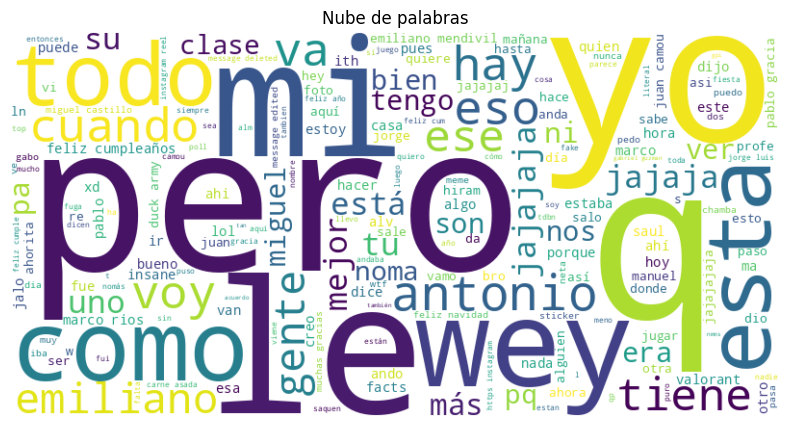

In [21]:
texto_todo = " ".join(df[df["Tipo"]=="texto"]["MensajeLimpio"])
wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate(texto_todo)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras")
plt.show()

## Visualizaciones
1. Usuarios más activos  
2. Distribución de mensajes por hora del día  
3. Mensajes por día de la semana  
4. Relación texto vs media por usuario


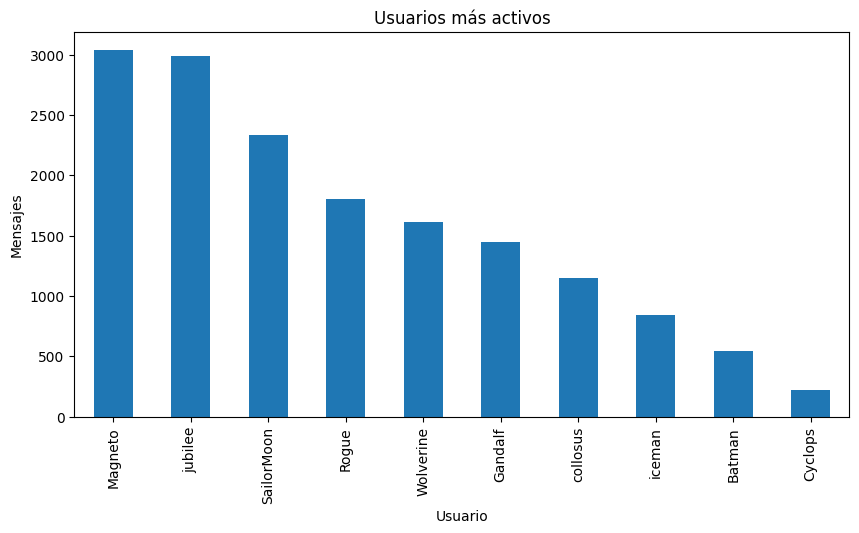

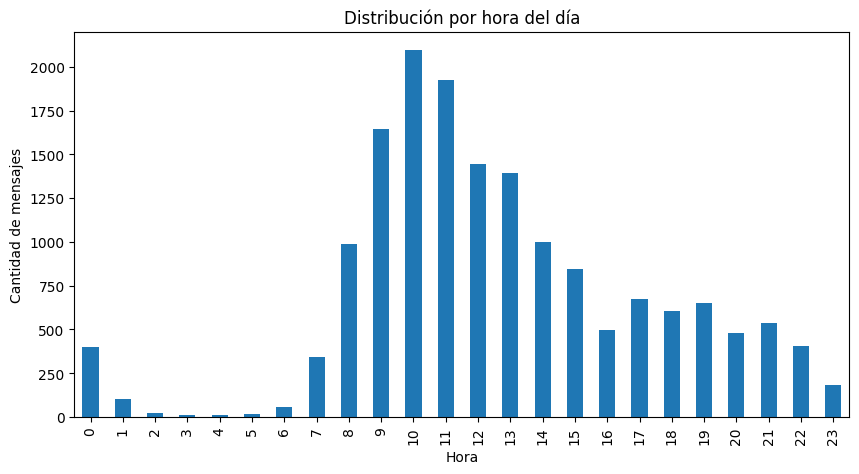

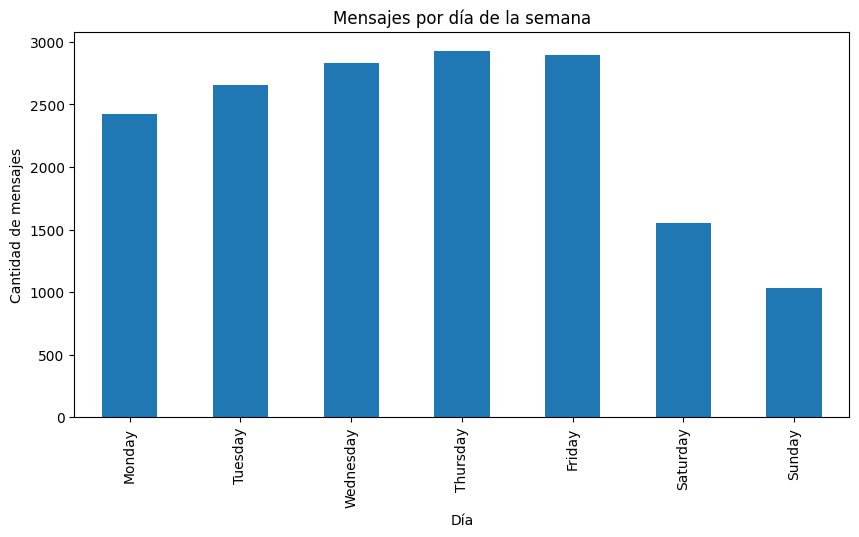

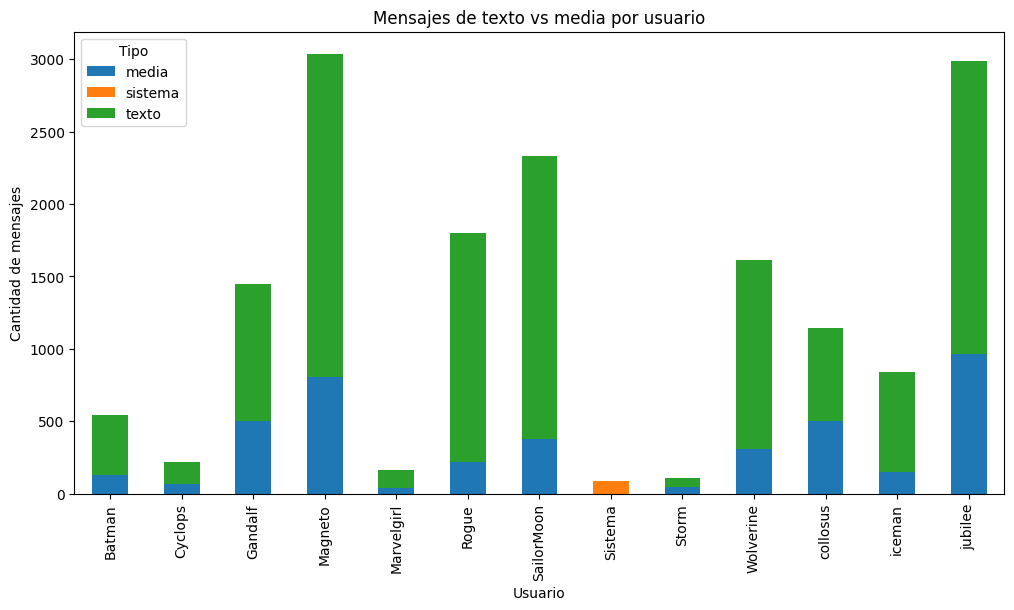

In [22]:

# Usuarios más activos
df["Usuario"].value_counts().head(10).plot(kind="bar", figsize=(10,5))
plt.title("Usuarios más activos")
plt.xlabel("Usuario")
plt.ylabel("Mensajes")
plt.show()

# Mensajes por hora
df["HoraNum"].value_counts().sort_index().plot(kind="bar", figsize=(10,5))
plt.title("Distribución por hora del día")
plt.xlabel("Hora")
plt.ylabel("Cantidad de mensajes")
plt.show()

# Mensajes por día de la semana
df["DiaSemana"].value_counts().reindex([
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"
]).plot(kind="bar", figsize=(10,5))
plt.title("Mensajes por día de la semana")
plt.xlabel("Día")
plt.ylabel("Cantidad de mensajes")
plt.show()

# Relación texto vs media por usuario
df.groupby("Usuario")["Tipo"].value_counts().unstack(fill_value=0).plot(
    kind="bar", stacked=True, figsize=(12,6)
)
plt.title("Mensajes de texto vs media por usuario")
plt.xlabel("Usuario")
plt.ylabel("Cantidad de mensajes")
plt.show()